## Getting Started with OpenRank

As we mix onchain and offchain wallet data, we end up with richer context and interaction graphs. By leveraging the eigentrust algorithm, we can identify and weight valuable peers in our network. From there, we can apply those weights to their onchain actions to create higher value feeds for channels, mints, trades, contracts, and much more.


In this notebook, we're going to walk through five steps:

1. pull graphs from dune for both seed and values graphs (pretrust and localtrust respectively)

2. compare graph staistics using networkx, getting reach and degree of the input graphs.

3. run openrank through sdk to get our eigentrust values.

4. get coverage and distribution of trust in the openrank eigentrust graph, using a grid search methodology (using scikit-learn).

5. run feeds through dune API to see the top contracts interacted with by OpenRank score weighting ([see Dune dashboard here)](https://dune.com/ilemi/openrank)


Let's start by installing the required python packages `openrank-sdk`, `dune-client`, `networkx`, `pandas`, and `scikit-learn`.



In [ ]:
!pip install openrank-sdk
!pip install dune-client
!pip install matplotlib
!pip install pandas
!pip install networkx
!pip install scikit-learn

## Get pretrust and localtrust graphs from Dune

Let's get the localtrust graph (the directed graph of i,j,v values) and the pretrust graph (the seeds we want to pick to emphasize localtrust values from) from Dune. For this notebook, I'm using all stablecoin and ETH transfers on base, optimism, and ethereum mainnet as my localtrust. To scope the graph down, I'm only including addresses from users who have casted in the /base channel on Farcaster.


**You'll need to generate a Dune API key and add it to a .env file in your directory**



In [ ]:
from dune_client.client import DuneClient
from dune_client.query import QueryBase
import pandas as pd

pd.set_option('display.float_format', '{:.6f}'.format)
dune = DuneClient.from_env() #set env DUNE_API_KEY
#dune = DuneClient(api_key="xxx") #or paste in your key directly instead of using env

# pull localtrust values https://dune.com/queries/3756692
query_values = QueryBase(query_id=3756692)
results_values = dune.get_latest_result(query_values)
values_df = pd.DataFrame(data=results_values.get_rows())
values_df.describe()

,i,j,v
count,91919.000000,91919.000000,91919.000000
mean,328740.245956,345684.446252,291.747464
std,138863.091575,144041.757037,9306.037263
min,3.000000,3.000000,0.000000
25%,254204.000000,257127.500000,1.498828
50%,303557.000000,315663.000000,6.346616
75%,426152.500000,453559.000000,32.601906
max,655619.000000,655573.000000,1815704.553762


Pretrust seeds are a bit more complicated, as I want to take the highest engagement casters in the /base channel but also want to make sure they are connected enough across the localtrust graph. Therefore I come up with seed value weighting of **`total engagement * distinct addresses in localtrust sent to`**.



In [ ]:
#pull pretrust values https://dune.com/queries/3756241
query_seed = QueryBase(query_id=3756241)
results_seed = dune.get_latest_result(query_seed)
seed_df = pd.DataFrame(data=results_seed.get_rows())

#we want to join the distinct fid trust values to the seed, and take a weighted engagement * trust score for seed_v.
fid_trust_sum = values_df.groupby('i')['j'].nunique().reset_index()
fid_trust_sum.columns = ['i','distinct_j']
seed_df = pd.merge(seed_df, fid_trust_sum, on = 'i', how = 'inner') #we remove any seeds that don't have a corresponding localtrust
seed_df['v'] = round(seed_df['distinct_j']*seed_df['engagement'],2)
seed_df = seed_df[['i','fname','engagement','distinct_j','v']]
seed_df = seed_df.sort_values(by='v', ascending=False)
seed_df.describe()

,i,engagement,distinct_j,v
count,2221.000000,594.000000,2221.000000,594.000000
mean,346619.375507,140.759092,3.082395,569.432290
std,133717.930974,582.898582,4.093277,2593.666668
min,12.000000,1.000000,1.000000,1.000000
25%,274677.000000,1.000000,1.000000,3.000000
50%,370463.000000,4.000000,2.000000,13.830000
75%,436037.000000,61.467514,3.000000,141.930000
max,625286.000000,8869.704210,70.000000,41632.100000


## Analyzing our localtrust graph using summary statistics

We want to now use networkx to better understand our graph shape. The reachability and degree of nodes will highly impact the coverage and distribution for OpenRank.



In [ ]:
import networkx as nx

#created graph for us to generate summary stats on
G = nx.from_pandas_edgelist(values_df, 'i', 'j', edge_attr='v', create_using=nx.DiGraph())

# Basic statistics
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
average_clustering = nx.average_clustering(G)

# Calculate % of reachable peers from pretrust seed nodes (use top 100 for testing)
reachable_nodes = set()
for node in seed_df["i"][:100]:
    reachable_nodes.update(nx.descendants(G, node))

# Include the pre-trust nodes themselves
reachable_nodes.update(seed_df["i"][:100])

# Calculate the percentage of reachable nodes
num_reachable_nodes = len(reachable_nodes)
total_nodes = len(G.nodes())
percentage_reachable = (num_reachable_nodes / total_nodes) * 100

# Calculate average number of outbound local trust arcs per reachable node
out_degrees = [G.degree(node) for node in reachable_nodes]
average_out_degree = sum(out_degrees) / len(reachable_nodes)

In [ ]:
print(f"Number of nodes: {num_nodes:,}")
print(f"Number of edges: {num_edges:,}")
print(f"Average clustering coeff (0-1): {round(average_clustering,3)}")

print(f"\nNumber of reachable peers from 100 pretrust nodes: {num_reachable_nodes:,}")
print(f"% of reachable peers from 100 pretrust nodes: {percentage_reachable:.2f}%")
print(f"Average degree per reachable node: {average_out_degree:.2f}")
#the reachable peers is more of a mental check of "qualified peers", instead of a desirable percentage to chase.

Number of nodes: 65,755
Number of edges: 91,919
Average clustering coeff (0-1): 0.117

Number of reachable peers from 100 pretrust nodes: 12,601
% of reachable peers from 100 pretrust nodes: 19.16%
Average degree per reachable node: 4.64


## Run OpenRank

Now that we're satisfied with our localtrust and pretrust graph values, let's run openrank using the sdk



In [ ]:
from openrank_sdk import EigenTrust

a = EigenTrust(alpha=0.5) #higher alpha weights pretrust more
localtrust = [l for l in values_df[["i", "j", "v"]].to_dict("records") if l['v'] > 0.0]
pretrust = [p for p in seed_df[["i", "v"]].to_dict("records") if p['v'] > 0.0]

scores = a.run_eigentrust(
    localtrust,
    pretrust[:100], #only use top 100
)

#we'll also publish it to eigentrust with the id 'base-transfer-50' for use later
eigentrust_id = 'base_transfer_50'
published_url = a.publish_eigentrust(eigentrust_id, scores)
scores_df = pd.DataFrame(scores)
scores_df.head()

,i,v
0,8152,0.074099
1,247143,0.047172
2,244310,0.034905
3,6373,0.029048
4,10095,0.026325


## Analyzing OpenRank results

Now let's take a look at the score coverage (nodes versus total nodes) and distribution (of trust scores)



In [ ]:
#get size of scores_df versus num_nodes
openrank_nodes = scores_df.shape[0]
coverage_ratio = openrank_nodes/num_nodes

print(f"Total OpenRank nodes: {openrank_nodes:,}")
print(f"Total Number of Nodes: {num_nodes:,}")
print(f"Coverage Ratio: {round(coverage_ratio*100,2)}%")

Total OpenRank nodes: 12,601
Total Number of Nodes: 65,755
Coverage Ratio: 19.16%


In [ ]:
#five number summary of the trust scores. ideally it is more log-normally distributed. higher pre-trust should push the "trust" distribution down more evenly to all nodes.
import numpy as np

scores_df[["v"]].apply(lambda x: np.log(x)).describe(include = 'all')

,v
count,12601.000000
mean,-24.245375
std,9.804491
min,-66.003906
25%,-28.994876
50%,-22.707119
75%,-17.662444
max,-2.602349


array([[<Axes: title={'center': 'v'}>]], dtype=object)

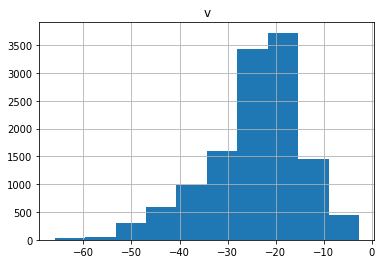

In [ ]:
scores_df[["v"]].apply(lambda x: np.log(x)).hist()

## Trying different OpenRank input combinations

To keep things simple, let's compare different alpha values and different seed sizes. In practice, you should compare completely different pretrust and localtrust values too.
We'll use a grid search method to iterate through openrank with these combinations.



In [ ]:
from sklearn.model_selection import ParameterGrid

localtrust = [l for l in values_df[["i", "j", "v"]].to_dict("records") if l['v'] > 0.0]
pretrust = [p for p in seed_df[["i", "v"]].to_dict("records") if p['v'] > 0.0]

param_grid = {'alpha': [0.1, 0.5, 0.9], 'seed_size': [10, 50, 500]}
results_log_trust = []
results_coverage = []

for s in list(ParameterGrid(param_grid)):
    alpha, seed_size = s["alpha"], s["seed_size"]
    eigentrust_id_tmp = f'ilemi_c47f23af-20ad-4318-b5d7-5230a47fad26-{alpha}-{seed_size}'

    a = EigenTrust(alpha=alpha)
    scores = []
    try: 
        scores = a.fetch_eigentrust(eigentrust_id_tmp)
    except:
        print('error while fetching')

    if not scores or len(scores) == 0:
        print(f'did not find {eigentrust_id_tmp}. running eigentrust....')
        scores = a.run_eigentrust(localtrust, pretrust[:seed_size])
        url = a.publish_eigentrust(eigentrust_id_tmp, scores)
        print(f'saved to {url}')

    scores_df = pd.DataFrame(scores)
    openrank_nodes = scores_df.shape[0]
    coverage_ratio = openrank_nodes / num_nodes
    mean_log_trust = scores_df["v"].apply(lambda x: np.log(x)).mean()
    
    results_log_trust.append({'alpha': s["alpha"], 'seed_size': s["seed_size"], 'mean_log_trust': mean_log_trust})
    results_coverage.append({'alpha': s["alpha"], 'seed_size': s["seed_size"], 'coverage_ratio': coverage_ratio})
    print(s, ' Mean Log-Trust: ', round(scores_df["v"].apply(lambda x: np.log(x)).mean(),2), f'Coverage Ratio: {round(coverage_ratio*100,2)}%')

df_log_trust = pd.DataFrame(results_log_trust)
df_coverage = pd.DataFrame(results_coverage)

# Pivot the dataframes to have grid search params as rows and columns
pivot_log_trust = df_log_trust.pivot(index='seed_size', columns='alpha', values='mean_log_trust')
pivot_coverage = df_coverage.pivot(index='seed_size', columns='alpha', values='coverage_ratio')

{'alpha': 0.1, 'seed_size': 10}  Mean Log-Trust:  -21.62 Coverage Ratio: 17.64%
{'alpha': 0.1, 'seed_size': 50}  Mean Log-Trust:  -20.86 Coverage Ratio: 18.78%
{'alpha': 0.1, 'seed_size': 500}  Mean Log-Trust:  -14.95 Coverage Ratio: 25.11%
{'alpha': 0.5, 'seed_size': 10}  Mean Log-Trust:  -28.01 Coverage Ratio: 17.64%
{'alpha': 0.5, 'seed_size': 50}  Mean Log-Trust:  -24.38 Coverage Ratio: 17.99%
{'alpha': 0.5, 'seed_size': 500}  Mean Log-Trust:  -17.61 Coverage Ratio: 25.11%
{'alpha': 0.9, 'seed_size': 10}  Mean Log-Trust:  -40.72 Coverage Ratio: 17.64%
{'alpha': 0.9, 'seed_size': 50}  Mean Log-Trust:  -37.47 Coverage Ratio: 18.78%
{'alpha': 0.9, 'seed_size': 500}  Mean Log-Trust:  -23.87 Coverage Ratio: 25.11%


In [ ]:
pivot_log_trust

alpha,0.100000,0.500000,0.900000
seed_size,,,
10,-21.616495,-28.008382,-40.723952
50,-20.856343,-24.376248,-37.473602
500,-14.949995,-17.606001,-23.868091


In [ ]:
pivot_coverage

alpha,0.100000,0.500000,0.900000
seed_size,,,
10,0.176428,0.176428,0.176428
50,0.187773,0.179895,0.187773
500,0.251084,0.251084,0.251084


As you can see, coverage only really changes with the size of the seed. The distribution of the scores will become more normal the higher your alpha value, because most localtrust graphs have exponentially distributed trust values already and the pretrust will act as a normalization factor.



## Putting OpenRank outputs into onchain feeds

We also want to sense check the recommendations we can generate from this openrank subjectively, so let's use some onchain feeds. Below, we're retrieving our openrank model of id "base_transfer_50" and then calling a dune query with the outputs. If you want to see other example feeds like NFT mints or DEX trades or Farcaster channels, [check out this Dune dashboard here](https://dune.com/ilemi/openrank)



In [ ]:
scores = a.fetch_eigentrust(eigentrust_id)
print('fetch_eigentrust', scores[:100])

fetch_eigentrust [{'i': '8152', 'v': 0.07409932813023677}, {'i': '247143', 'v': 0.047171951627658595}, {'i': '244310', 'v': 0.03490532698898475}, {'i': '6373', 'v': 0.029047803234081928}, {'i': '10095', 'v': 0.02632526019081967}, {'i': '5774', 'v': 0.023762309848814944}, {'i': '3642', 'v': 0.02279850860760785}, {'i': '424317', 'v': 0.020495605928246757}, {'i': '211693', 'v': 0.020479819430298245}, {'i': '424937', 'v': 0.019272593862909224}, {'i': '7620', 'v': 0.01909731964827271}, {'i': '262938', 'v': 0.01795757796292163}, {'i': '528025', 'v': 0.017094013271228916}, {'i': '9135', 'v': 0.015207833463102893}, {'i': '191', 'v': 0.01401580465752276}, {'i': '2163', 'v': 0.013726822667627064}, {'i': '271713', 'v': 0.013473865762485672}, {'i': '281450', 'v': 0.01311312451256839}, {'i': '318094', 'v': 0.012423758107232345}, {'i': '276562', 'v': 0.010360799448196227}, {'i': '384835', 'v': 0.008998940179991149}, {'i': '244147', 'v': 0.00812764234569063}, {'i': '399485', 'v': 0.007974701985914158

In [ ]:
from dune_client.types import QueryParameter
from dune_client.client import DuneClient
from dune_client.query import QueryBase

dune = DuneClient.from_env()
query = QueryBase(
    query_id=3815727, #https://dune.com/queries/3815727
    params=[
        QueryParameter.text_type(name="eigentrust_id", value=eigentrust_id) #lets get trending contracts for our given eigentrust graph
    ],
)
# # run new, it will probably timeout
# results_df = dune.run_query_dataframe(query)

# check app for if it ran, you can then just pull latest only
results = dune.get_latest_result(query)
results_df = pd.DataFrame(results.get_rows())

# peak at results
results_df.head(10)

,blockchain,callers,contract,contract_days_old,contract_name,deployer,example_hash,ranked_calls,times_called,total_calls,unique_callers
0,base,1579,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,154,uniswap: UniversalRouter,0x946e9c780f3c79d80e51e68d259d0d7e794f2124,0x4a310fda4ae393d2ae6373efd56f24332e76200093ba...,16432.221778,15157019,9832,1299566
1,base,3702,0x556e182ad2b72f5934c2215d6a56cfc19936fdb7,2,build_airdrop1_distribution: BuildAirdrop1Dist...,0x8cee4a80fdb864c2b7092f3dfad1f597daec64aa,0x1bc042301a750c4729445a509323ac93484d94f178a7...,1991.150778,25301,3702,25017
2,base,101,0x3ccc78545f675a188b7521f7f4b4791995752635,17,ape_store: Router,0xade256e1c2763b8766efe1eeb7c578d93f621f6f,0xd1431b7da0b151b4906a965831b1e772344904a94156...,54.796141,198319,3166,10067
3,base,1344,0x4ed4e862860bed51a9570b96d89af5e1b0efefed,159,degen_token: DegenToken,0x3c12b77ae8b7dd1feb63d1d6a2a819acda0a41d2,0xcb6a1e921441f9107d344fa3de4ca92e66531dc00a6c...,4207.615111,1025138,2938,262635
4,base,526,0xd1ca1f4dbb645710f5d5a9917aa984a47524f49a,112,None,0x3df3c01b72dc5d63565af0bcb20d847227c2201a,0x9687bf601c23ce39092c4c2c2f42be76b251abe837dc...,234.320932,627341,2228,70087
5,arbitrum,668,0x9e6ef7f75ad88d4edb4c9925c94b769c5b0d6281,774,project_galaxy: SpaceStationV2,0x5ffc120734ce00002b43919d27e70d881f02f8ef,0xbb3931fd5b807f05037ed20998a175b346ae3503d02a...,83.244636,6566569,1782,1247665
6,polygon,555,0x1195cf65f83b3a5768f3c496d3a05ad6412c64b7,127,cube: CUBE,0xf1c0df2381ac4a6cac9c866ddbde3c3d641a1337,0xa4f0af186c0ceb8773e99b0d29ac8fe23e9abb45c04d...,125.437090,1099613,1693,247309
7,base,338,0x6b2c0c7be2048daa9b5527982c29f48062b34d58,319,None,0x06c95a3934d94d5ae5bf54731bd2840cefee6f87,0x217e0f588bc5b0288f329f316678acbcc5fe3cd98c96...,459.392434,732576,1629,91034
8,base,1386,0x3c281a39944a2319aa653d81cfd93ca10983d234,32,build: GovernableERC20,0xa97ca732232cd2acab9038a1943fe2a79fa1ccc8,0xca9df8f8fe159bfbb36e1dbab2933727a2a25319eb7b...,272.151072,30993,1549,17594
9,base,120,0xedd1c688d8e75849d52316237e6634e382b03310,8,None,0x3037de6d4f656cc127eae1ca96711d62edab110a,0x572e1866a6a7b4b67f6b1721f053b595440eec880ead...,1682.327720,17382,1531,1552
